In [74]:
import sqlalchemy as sa
import pandas as pd

import json
import logging
import requests

from sqlalchemy import inspect
from sqlalchemy.sql import text

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
def get_database_engine(environment: str):
    if environment == 'production':
        url = 'https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json'
        params = requests.get(url).json()['params']
        engine = sa.create_engine(
            f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}/{params['dbname']}"
        )
    
    elif environment == 'staging':
        with open('alerceread_db_staging.json', 'r', encoding='utf-8') as f:
            params = json.load(f)
        engine = sa.create_engine(
            f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}:{params['port']}/{params['dbname']}"
        )
    else:
        raise ValueError(f'Environment "{environment}" not defined')
        
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    print('Available Tables:\n', tables)
    return engine

In [76]:
ENVIRONMENT = "production"
engine = get_database_engine(environment=ENVIRONMENT)
engine.begin()

Available Tables:
 ['outlier', 'feature_version', 'gaia_ztf', 'alembic_version', 'ss_ztf', 'allwise', 'non_detection', 'step', 'taxonomy', 'feature', 'pipeline', 'lc_classifier_top', 'lc_classifier_periodic', 'lc_classifier_transient', 'magstat', 'lc_classifier', 'stamp_classifier', 'dataquality', 'object', 'lc_classifier_stochastic', 'lc_classifier_beta', 'forced_photometry', 'lc_classifier_bhrf_forced_phot_childs', 'reference', 'ps1_ztf', 'xmatch', 'detection', 'probability']


In [66]:
import glob

unique_oids = [oid.split('/')[-1].split('.')[0] for oid in glob.glob('db_production/data/*') if oid.find('detections_log') == -1]
#oids = [oids[0]]
oids = ['ZTF18adatzee']
oids = [f"'{oid}'" for oid in unique_oids]


In [67]:
len(oids)

100

## Query to BBDD

### Detections and Forced Photometry

In [68]:
query_detections = f"""
    SELECT * FROM detection
    WHERE oid IN ({','.join(oids)}) and rb >= 0.55;
"""

detections = pd.read_sql_query(query_detections, con=engine)
display(detections.head())
print(detections.shape)
print(detections.columns)

,oid,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
0,ZTF17aaagsek,683377630515010001,58437.377639,2,683377630515,20.110601,-1,683,100.451844,-4.859769,...,0.2381,410120205.0,17.832350,0.042015,0.043968,True,False,7.123086e+17,False,bulk_1.0.0
1,ZTF17aaagsek,687454970515015004,58441.454977,1,687454970515,20.466244,1,687,100.451858,-4.859860,...,0.2065,410120105.0,17.725166,0.023189,0.027412,True,False,7.103330e+17,False,bulk_1.0.0
2,ZTF17aaagsek,695418660515010005,58449.418669,2,695418660515,19.863800,-1,695,100.451855,-4.859789,...,0.4200,NaN,17.801094,0.054913,0.056337,True,False,7.103330e+17,False,bulk_1.0.0
3,ZTF17aaagsek,696395530515015006,58450.395532,2,696395530515,20.165300,1,696,100.451864,-4.859833,...,0.3301,NaN,17.444149,0.021727,0.023542,True,False,7.103330e+17,False,bulk_1.0.0
4,ZTF17aaagsek,710332970515015006,58464.332975,1,710332970515,20.443193,1,710,100.451944,-4.859813,...,0.1998,410120105.0,17.705051,0.018551,0.023454,True,False,7.263154e+17,False,bulk_1.0.0


(18751, 30)
Index(['oid', 'candid', 'mjd', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'ra', 'dec', 'magpsf', 'sigmapsf', 'magap', 'sigmagap', 'distnr', 'rb',
       'rbversion', 'drb', 'drbversion', 'magapbig', 'sigmagapbig', 'rfid',
       'magpsf_corr', 'sigmapsf_corr', 'sigmapsf_corr_ext', 'corrected',
       'dubious', 'parent_candid', 'has_stamp', 'step_id_corr'],
      dtype='object')


In [69]:
len(detections.oid.unique())

100

In [70]:
# FORCED PHOTOMETRY
query_forced_photometry = f"""
                    SELECT * FROM forced_photometry
                    WHERE oid in ({','.join(oids)}) and procstatus in ('0', '57');
                    """

forced_photometry = pd.read_sql_query(query_forced_photometry, con=engine)
display(forced_photometry.head())
print(forced_photometry.shape)
print(forced_photometry.columns)

,pid,oid,mjd,fid,ra,dec,e_ra,e_dec,mag,e_mag,...,diffmaglim,programid,procstatus,distnr,ranr,decnr,magnr,sigmagnr,chinr,sharpnr
0,2505441943315,ZTF18acuyrbh,60259.441944,2,92.094735,6.332155,None,None,14.304023,0.002505,...,19.947201,1,0,0.478727,92.094604,6.332199,12.995999,0.019,1.132,-0.051
1,2503403433315,ZTF18acuyrbh,60257.403437,2,92.094735,6.332155,None,None,14.217422,0.002249,...,20.047199,1,0,0.478727,92.094604,6.332199,12.995999,0.019,1.132,-0.051
2,2506377415615,ZTF17aaanwzg,60260.377419,2,78.341707,15.188151,None,None,16.624176,0.004746,...,20.360701,1,0,0.376115,78.341812,15.188140,14.888000,0.016,0.626,-0.048
3,2504397755615,ZTF17aaanwzg,60258.397755,1,78.341707,15.188151,None,None,16.987900,0.010406,...,20.294500,1,0,0.369684,78.341812,15.188145,15.804000,0.016,0.729,-0.061
4,2508466601815,ZTF18acubkiz,60262.466609,2,109.689618,-3.680567,None,None,19.046825,0.027320,...,20.743099,1,0,0.194954,109.689674,-3.680575,16.415001,0.016,0.741,-0.036


(8568, 42)
Index(['pid', 'oid', 'mjd', 'fid', 'ra', 'dec', 'e_ra', 'e_dec', 'mag',
       'e_mag', 'mag_corr', 'e_mag_corr', 'e_mag_corr_ext', 'isdiffpos',
       'corrected', 'dubious', 'parent_candid', 'has_stamp', 'field', 'rcid',
       'rfid', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'magzpsci',
       'magzpsciunc', 'magzpscirms', 'clrcoeff', 'clrcounc', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'programid', 'procstatus',
       'distnr', 'ranr', 'decnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr'],
      dtype='object')


In [71]:
len(forced_photometry.oid.unique())

97

### To compute Features locally

* Queries (Reference, Xmatch, AllWise, PanStarr)

In [72]:
def patch_wise(oid_list):
    columns = ["oid", "w1mpro", "w2mpro", "w3mpro", "w4mpro"]
    df = pd.DataFrame({"oid": oid_list})  # Fill only the oid column
    for col in columns[1:]:  # Add empty columns for the rest
        df[col] = None
    return df

In [73]:
# REFERENCE
query_reference = f"""
                    SELECT oid, rfid, sharpnr, chinr FROM reference
                    WHERE oid in ({','.join(oids)}) and chinr >= 0;
                    """
reference = pd.read_sql_query(query_reference, con=engine)
reference = reference.drop_duplicates("rfid")

# XMATCH
query_xmatch = f"""
                SELECT oid, oid_catalog, dist FROM xmatch
                WHERE oid in ({','.join(oids)}) and catid='allwise';
                """
xmatch = pd.read_sql_query(query_xmatch, con=engine)
xmatch = xmatch.sort_values("dist").drop_duplicates("oid")
oid_catalog = [f"'{oid}'" for oid in xmatch["oid_catalog"].values]

#########################################################################################
# ALL WISE
query_wise = f"""
            SELECT oid_catalog, w1mpro, w2mpro, w3mpro, w4mpro FROM allwise
            WHERE oid_catalog in ({','.join(oid_catalog)});
            """
try:
    wise = pd.read_sql_query(query_wise, con=engine).set_index("oid_catalog")
    wise = pd.merge(xmatch, wise, on="oid_catalog", how="outer")
    wise = wise[["oid", "w1mpro", "w2mpro", "w3mpro", "w4mpro"]].set_index("oid")
except:
    wise = patch_wise(oids)
    logging.warning("wise patched")

# PANSTARR
query_ps = f"""
            SELECT oid, sgscore1, sgmag1, srmag1, simag1, szmag1, distpsnr1 FROM ps1_ztf
            WHERE oid in ({','.join(oids)});
            """
ps = pd.read_sql_query(query_ps, con=engine)
ps = ps.drop_duplicates("oid").set_index("oid")
#########################################################################################

xmatch = pd.concat([wise, ps], axis=1).reset_index()

display(reference)
display(xmatch)

,oid,rfid,sharpnr,chinr
0,ZTF17aaagsek,410120205,-0.002,0.305
1,ZTF17aaagsek,410120105,-0.035,0.863
2,ZTF17aaagsvd,411120239,0.029,0.600
3,ZTF17aaagsvd,411120139,-0.005,0.482
4,ZTF17aaaidli,361120149,0.008,0.742
...,...,...,...,...
214,ZTF21acqvidm,360120100,-0.022,1.220
215,ZTF21acqvidm,360120200,-0.034,0.815
216,ZTF21acqvidm,361120113,-0.029,0.833
217,ZTF21acqvidm,361120213,-0.013,0.677


,oid,w1mpro,w2mpro,w3mpro,w4mpro,sgscore1,sgmag1,srmag1,simag1,szmag1,distpsnr1
0,ZTF19acxhzcj,NaN,NaN,NaN,NaN,0.994167,12.9060,12.8210,12.8400,12.8690,0.219123
1,ZTF20abyosui,NaN,NaN,NaN,NaN,1.000000,13.0260,12.5190,12.3030,12.1960,0.412721
2,ZTF18abykvfz,NaN,NaN,NaN,NaN,0.825286,14.5757,13.7388,13.1470,12.8970,1.088680
3,ZTF17aacyjcj,NaN,NaN,NaN,NaN,0.991667,15.6387,14.2729,13.3850,12.9390,0.331253
4,ZTF18acduuzp,NaN,NaN,NaN,NaN,0.997917,17.8802,16.8169,16.2008,15.8486,0.343670
...,...,...,...,...,...,...,...,...,...,...,...
95,ZTF18aczuhzw,NaN,NaN,NaN,NaN,0.990208,16.0045,15.5759,15.4171,15.3584,0.320614
96,ZTF19aaakvyf,NaN,NaN,NaN,NaN,1.000000,13.9092,13.3644,13.4440,13.4393,0.219809
97,ZTF19aaalawx,NaN,NaN,NaN,NaN,1.000000,16.5504,16.6034,16.3652,16.3599,0.402393
98,ZTF19aaercen,NaN,NaN,NaN,NaN,0.988702,17.8587,17.2878,17.0282,16.8840,0.183777


* Create Astro Object

In [12]:
import numpy as np
from lc_classifier.utils import (
    create_astro_object,
    EmptyLightcurveException,
)

def patch_xmatch_by_oid(oid: str):
    data = {
        "oid": [oid],
        "w1mpro": [np.nan],
        "w2mpro": [np.nan],
        "w3mpro": [np.nan],
        "w4mpro": [np.nan],
        "sgscore1": [np.nan],
        "sgmag1": [np.nan],
        "srmag1": [np.nan],
        "simag1": [np.nan],
        "szmag1": [np.nan],
        "distpsnr1": [np.nan],
    }
    return pd.DataFrame(data)

def dataframes_to_astro_object_list(
    detections,
    forced_photometry,
    xmatch,
    reference,
    features=None,
    data_origin="database",
    verbose=True,
):
    oids = detections["oid"].unique()
    detections.set_index("oid", inplace=True)
    detections.sort_index(inplace=True)
    forced_photometry_columns = forced_photometry.columns
    forced_photometry.set_index("oid", inplace=True)
    forced_photometry.sort_index(inplace=True)
    xmatch.set_index("oid", inplace=True)
    reference_columns = reference.columns
    reference.set_index("oid", inplace=True)
    astro_objects_list = []
    astro_objects_dict = dict()
    for oid in oids:
        try:
            xmatch_oid = xmatch.loc[[oid]].reset_index()
        except:
            logging.warning("xmatch metadata patched!")
            xmatch_oid = patch_xmatch_by_oid(oid=oid).reset_index()

        assert len(xmatch_oid) == 1
        xmatch_oid = xmatch_oid.iloc[0]
        if oid in forced_photometry.index:
            forced_photometry_oid = forced_photometry.loc[[oid]].reset_index()
        else:
            forced_photometry_oid = pd.DataFrame(columns=forced_photometry_columns)

        if oid in reference.index:
            reference_oid = reference.loc[[oid]].reset_index()
        else:
            reference_oid = pd.DataFrame(columns=reference_columns)
        try:
            ao = create_astro_object(
                data_origin=data_origin,
                detections=detections.loc[[oid]].reset_index(),
                forced_photometry=forced_photometry_oid,
                xmatch=xmatch_oid,
                reference=reference_oid,
                non_detections=None,
            )
            if features is not None:
                """add features from db"""
                try:
                    ao.features = features.loc[features.oid == oid] #[["name", "value", "fid", "version"]]
                except:
                    ao.features = None
        except EmptyLightcurveException:
            continue

        astro_objects_list.append(ao)
        astro_objects_dict[oid] = ao
    return astro_objects_list, astro_objects_dict

In [24]:
# GET FEATURES
query_features = f"""
                SELECT * FROM feature as f 
                WHERE f.oid in ({','.join(oids)}) and f.version = '27.5.0';
                """

features = pd.read_sql_query(query_features, con=engine)
#features = features.copy()
features['fid'] = features['fid'].map({1: 'g', 2: 'r', 12: 'g,r', 0: None})
features['name'] = features['name'].str.replace('/', '_')
#features = features.drop_duplicates(subset=["oid", "name", "fid"])
features

,oid,name,value,fid,version
0,ZTF17aaagsek,Amplitude,5.968180e-01,g,27.5.0
1,ZTF17aaagsek,Amplitude,6.442189e-01,r,27.5.0
2,ZTF17aaagsek,AndersonDarling,1.000000e+00,g,27.5.0
3,ZTF17aaagsek,AndersonDarling,1.000000e+00,r,27.5.0
4,ZTF17aaagsek,Autocor_length,7.000000e+00,g,27.5.0
...,...,...,...,...,...
20621,ZTF23abthyqt,ulens_u0,1.932796e-11,g,27.5.0
20622,ZTF23abthyqt,ulens_u0,3.141843e-11,r,27.5.0
20623,ZTF23abthyqt,W1-W2,-4.500008e-02,None,27.5.0
20624,ZTF23abthyqt,W2-W3,-3.000002e-01,None,27.5.0


In [14]:
ao_list, ao_dict = dataframes_to_astro_object_list(
    detections=detections,
    forced_photometry=forced_photometry,
    xmatch=xmatch,
    reference=reference,
    features=features,
)

In [15]:
for oid_used in unique_oids:
    ao_from_step = pd.read_pickle(f'db_production/data/{oid_used}.pkl')
    ao_from_db = ao_dict[oid_used]
    last_mjd = ao_from_step.detections.sort_values(by='mjd', ascending=False).mjd.iloc[0]

    if ao_from_db.detections.shape[0] != ao_from_step.detections.shape[0] or ao_from_db.forced_photometry.shape[0] != ao_from_step.forced_photometry.shape[0]:
        print(f'\nOID: {oid_used} - Last MJD: {last_mjd}')

    if ao_from_db.detections.shape[0] != ao_from_step.detections.shape[0]:
        print(f'- Num. Detecciones: From BBDD: {ao_from_db.detections.shape[0]} | From Step: {ao_from_step.detections.shape[0]}')

    if ao_from_db.forced_photometry.shape[0] != ao_from_step.forced_photometry.shape[0]:
        print(f'- Num. Fotometria Forzada: From BBDD: {ao_from_db.forced_photometry.shape[0]} | From Step: {ao_from_step.forced_photometry.shape[0]}')



OID: ZTF19aaerbsi - Last MJD: 60754.23001160007
- Num. Detecciones: From BBDD: 440 | From Step: 438

OID: ZTF17aaaidli - Last MJD: 60754.230486100074
- Num. Detecciones: From BBDD: 688 | From Step: 686

OID: ZTF18acwwbsg - Last MJD: 60754.23096060008
- Num. Detecciones: From BBDD: 1108 | From Step: 1106

OID: ZTF19aaercvx - Last MJD: 60754.23001160007
- Num. Detecciones: From BBDD: 536 | From Step: 534

OID: ZTF19aaerdxm - Last MJD: 60754.23001160007
- Num. Detecciones: From BBDD: 268 | From Step: 266

OID: ZTF19aaererg - Last MJD: 60754.23001160007
- Num. Detecciones: From BBDD: 668 | From Step: 666

OID: ZTF19aaerbyb - Last MJD: 60754.23001160007
- Num. Detecciones: From BBDD: 268 | From Step: 266

OID: ZTF18adayhpt - Last MJD: 60754.230486100074
- Num. Detecciones: From BBDD: 126 | From Step: 124

OID: ZTF18aczrhqa - Last MJD: 60754.23096060008
- Num. Detecciones: From BBDD: 1122 | From Step: 1120

OID: ZTF19aadmgeg - Last MJD: 60754.230486100074
- Num. Detecciones: From BBDD: 662 

In [57]:
from lc_classifier.utils import all_features_from_astro_objects

In [58]:
df = all_features_from_astro_objects(ao_list)
df

OID ZTF17aaanwzg no tiene todas las Features
OID ZTF18acduuzp no tiene todas las Features


,Amplitude_g,Amplitude_r,AndersonDarling_g,AndersonDarling_r,Autocor_length_g,Autocor_length_r,Beyond1Std_g,Beyond1Std_r,"color_variation_g,r",Con_g,...,ulens_mag0_r,ulens_t0_g,ulens_t0_r,ulens_tE_g,ulens_tE_r,ulens_u0_g,ulens_u0_r,W1-W2_nan,W2-W3_nan,W3-W4_nan
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaagsek,0.596818,0.644219,1.000000,1.000000,7.0,6.0,0.239130,0.228814,0.423135,0.000000,...,17.645045,847.515496,2037.857414,41.654620,124.326139,1.465385e+00,5.340091e-01,-0.268999,4.131999,3.455000
ZTF17aaagsvd,0.233869,0.238684,1.000000,1.000000,1.0,1.0,0.357724,0.314607,0.927816,0.000000,...,12.570569,715.300160,1425.185489,2.297720,9.268396,1.283017e+00,1.007031e+00,-0.043000,-0.049000,2.353000
ZTF17aaaidli,0.570771,0.415594,1.000000,1.000000,1.0,1.0,0.455621,0.482143,0.361899,0.000000,...,14.046808,1896.201236,1858.862358,19.865941,0.061141,1.188805e-01,5.618882e-01,-0.016999,0.384999,3.466001
ZTF17aaaidon,0.393651,0.388360,1.000000,1.000000,1.0,1.0,0.297101,0.252033,0.322971,0.000000,...,14.989279,745.818514,-6.086966,6.811889,702.289522,1.585806e+00,1.647976e+00,-0.078000,0.717000,3.783000
ZTF17aaaiebm,0.329401,0.294707,1.000000,1.000000,1.0,1.0,0.300000,0.356250,0.361491,0.000000,...,15.905551,1938.269566,332.410175,18.896005,14.050674,1.231171e+00,1.605237e+00,-0.054000,1.736000,3.177000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aahcdqe,0.159536,0.199201,0.999630,0.993403,2.0,1.0,0.200000,0.111111,NaN,0.000000,...,12.409238,1429.788637,1424.273675,28.376010,31.321506,5.615733e-17,6.741144e-10,-0.128000,0.222000,0.186000
ZTF21accjhck,0.099557,0.074499,1.000000,1.000000,3.0,2.0,0.161290,0.086957,0.168554,0.068966,...,15.387425,184.451592,931.161554,254.908445,4376.110803,1.189879e+00,2.903106e-01,0.045000,0.208000,1.453000
ZTF21acoiozz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.626603,NaN,...,13.981505,397.810686,492.885572,0.054168,0.089560,5.329279e+00,8.366091e-02,-0.082000,0.124001,1.396999


In [59]:
from alerce_classifiers.base.dto import InputDTO
from alerce_classifiers.base._types import *

input_dto = InputDTO(
        Detections(pd.DataFrame()),
        NonDetections(pd.DataFrame()),
        Features(df),
        Xmatch(pd.DataFrame()),
        Stamps(pd.DataFrame()),
    )

In [61]:
from alerce_classifiers.squidward.model import (
    SquidwardFeaturesClassifier,
    SquidwardMapper,
)

SQUIDWARD_MODEL = "https://alerce-models.s3.amazonaws.com/squidward/1.1.5/hierarchical_random_forest_model.pkl"

model = SquidwardFeaturesClassifier(
    model_path=SQUIDWARD_MODEL,
    mapper=SquidwardMapper(),
)

predictions = model.predict(input_dto)
df_local_hbrf = predictions.probabilities
df_local_hbrf = df_local_hbrf.reset_index()
df_local_hbrf = df_local_hbrf.melt(id_vars=['oid'], var_name='class_name', value_name='probability')
df_local_hbrf['ranking'] = df_local_hbrf.groupby('oid')['probability'].rank(method="first", ascending=False).astype(int)
df_local_hbrf

,oid,class_name,probability,ranking
0,ZTF17aaagsek,AGN,0.007215,17
1,ZTF17aaagsvd,AGN,0.000557,17
2,ZTF17aaaidli,AGN,0.000371,12
3,ZTF17aaaidon,AGN,0.000389,17
4,ZTF17aaaiebm,AGN,0.001502,14
...,...,...,...,...
2151,ZTF21aahcdqe,YSO,0.161575,1
2152,ZTF21accjhck,YSO,0.211288,1
2153,ZTF21acoiozz,YSO,0.225950,1
2154,ZTF21acqvidm,YSO,0.114521,2


In [62]:
query_to_prod_hbrf = f"""
            SELECT * FROM probability as p
            WHERE oid  in ({','.join(oids)})
                    and p.classifier_name = 'LC_classifier_BHRF_forced_phot(beta)' 
                    and classifier_version = '1.1.5';
        """

df_prod_hbrf = pd.read_sql_query(query_to_prod_hbrf, con=engine) #[df_local_hbrf.columns]
df_prod_hbrf

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF17aaagsek,LC_classifier_BHRF_forced_phot(beta),1.1.5,AGN,0.014456,13
1,ZTF17aaagsek,LC_classifier_BHRF_forced_phot(beta),1.1.5,Blazar,0.040032,6
2,ZTF17aaagsek,LC_classifier_BHRF_forced_phot(beta),1.1.5,CEP,0.071556,4
3,ZTF17aaagsek,LC_classifier_BHRF_forced_phot(beta),1.1.5,CV/Nova,0.422560,1
4,ZTF17aaagsek,LC_classifier_BHRF_forced_phot(beta),1.1.5,DSCT,0.002412,21
...,...,...,...,...,...,...
1843,ZTF21acqvidm,LC_classifier_BHRF_forced_phot(beta),1.1.5,SNII,0.001980,16
1844,ZTF21acqvidm,LC_classifier_BHRF_forced_phot(beta),1.1.5,SNIIb,0.000468,22
1845,ZTF21acqvidm,LC_classifier_BHRF_forced_phot(beta),1.1.5,SNIIn,0.001692,18
1846,ZTF21acqvidm,LC_classifier_BHRF_forced_phot(beta),1.1.5,TDE,0.007596,13


In [63]:
df_hbrf = df_local_hbrf.merge(df_prod_hbrf, on=['oid', 'class_name'], suffixes=('_local', '_prod'))
df_hbrf

,oid,class_name,probability_local,ranking_local,classifier_name,classifier_version,probability_prod,ranking_prod
0,ZTF17aaagsek,AGN,0.007215,17,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.014456,13
1,ZTF17aaagsvd,AGN,0.000557,17,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.000560,13
2,ZTF17aaaidli,AGN,0.000371,12,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.000432,14
3,ZTF17aaaidon,AGN,0.000389,17,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.000816,18
4,ZTF17aaaiebm,AGN,0.001502,14,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.000600,18
...,...,...,...,...,...,...,...,...
1799,ZTF19acnqhkm,YSO,0.070633,5,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.075600,5
1800,ZTF20aaibsiu,YSO,0.063439,5,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.081216,5
1801,ZTF21aahcdqe,YSO,0.161575,1,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.186260,1
1802,ZTF21accjhck,YSO,0.211288,1,LC_classifier_BHRF_forced_phot(beta),1.1.5,0.217248,1


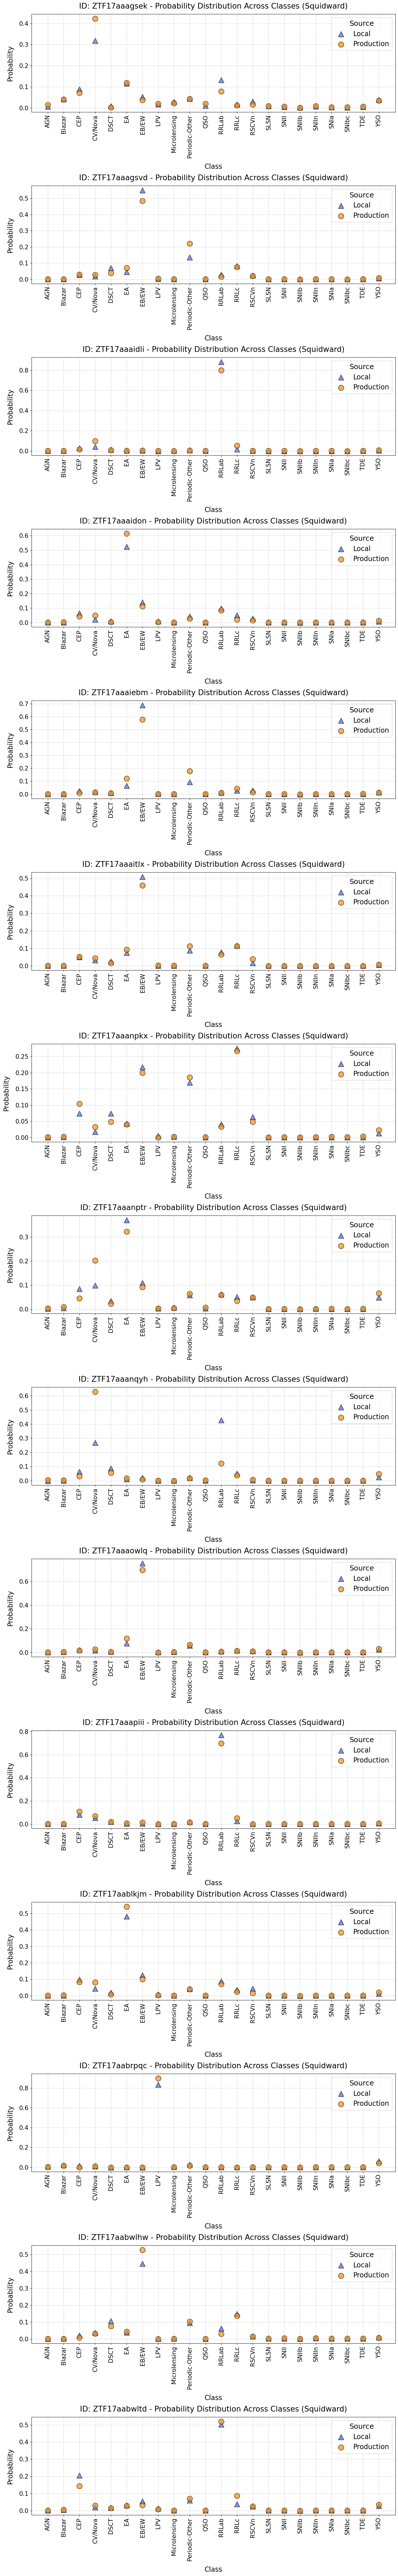

In [64]:
import matplotlib.pyplot as plt
import numpy as np

fs = 15

# Definir colores y estilos para Local y Producción
color_local = "royalblue"
color_prod = "darkorange"

unique_oids = sorted(df_hbrf['oid'].unique())
num_selected_oids = min(15, len(unique_oids))  # Asegurar que no seleccionamos más de los disponibles
selected_oids = np.random.choice(unique_oids, num_selected_oids, replace=False)
selected_oids = unique_oids[:15]

# Crear la figura con subplots dinámicos
fig, axes = plt.subplots(num_selected_oids, 1, figsize=(14, 6 * num_selected_oids))

# Si hay un solo objeto, convertir `axes` en una lista para iterar
if num_selected_oids == 1:
    axes = [axes]

# Iterar sobre los oids seleccionados
for ax, oid in zip(axes, selected_oids):
    df_oid = df_hbrf[df_hbrf['oid'] == oid]
    
    # Convertir las clases en valores numéricos
    class_labels = df_oid['class_name'].unique()
    class_to_x = {cls: i for i, cls in enumerate(class_labels)}
    df_oid = df_oid.copy()  # Create an explicit copy
    df_oid.loc[:, 'class_x'] = df_oid['class_name'].map(class_to_x)

    # Graficar datos de Local
    ax.scatter(
        df_oid['class_x'],
        df_oid['probability_local'],
        color=color_local,
        marker="^",
        s=180,
        label="Local",
        edgecolors="black",
        linewidths=1.2,
        alpha=0.7
    )

    # Graficar datos de Producción
    ax.scatter(
        df_oid['class_x'],
        df_oid['probability_prod'],
        color=color_prod,
        marker="o",
        s=180,
        label="Production",
        edgecolors="black",
        linewidths=1.2,
        alpha=0.7
    )

    # Personalizar etiquetas y diseño
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels, rotation=90, fontsize=fs)
    ax.tick_params(axis='y', labelsize=fs)

    ax.set_xlabel('Class', fontsize=fs+2, labelpad=14)
    ax.set_ylabel('Probability', fontsize=fs+2, labelpad=14)
    
    # Título con ID del objeto
    ax.set_title(f'ID: {oid} - Probability Distribution Across Classes (Squidward)', fontsize=fs+4, pad=14, color='black')
    
    ax.legend(fontsize=fs+2, title="Source", title_fontsize=fs+3)
    ax.grid(True, linestyle="--", alpha=0.7)

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()